<a href="https://colab.research.google.com/github/paulomikundu/Anomaly-Detection-in-financial-transaction/blob/main/FINAL_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Initial Data:
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0      0.0             0.0  
1  M2044282225             0.0             0.0      0.0             0.0  
2   C553264065             0.0             0.0      1.0             0.0  
3    C38997010         21182.0             0.0      1.0             0.0  
4  M1230701703             0.0             0.0      0.0             0.0  


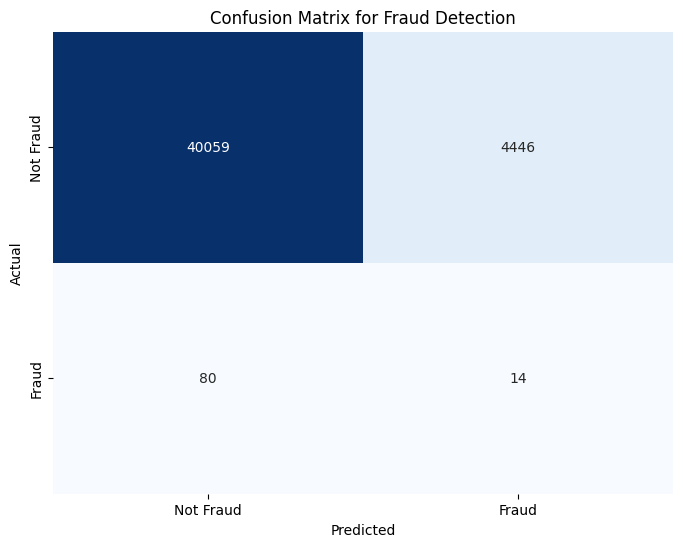

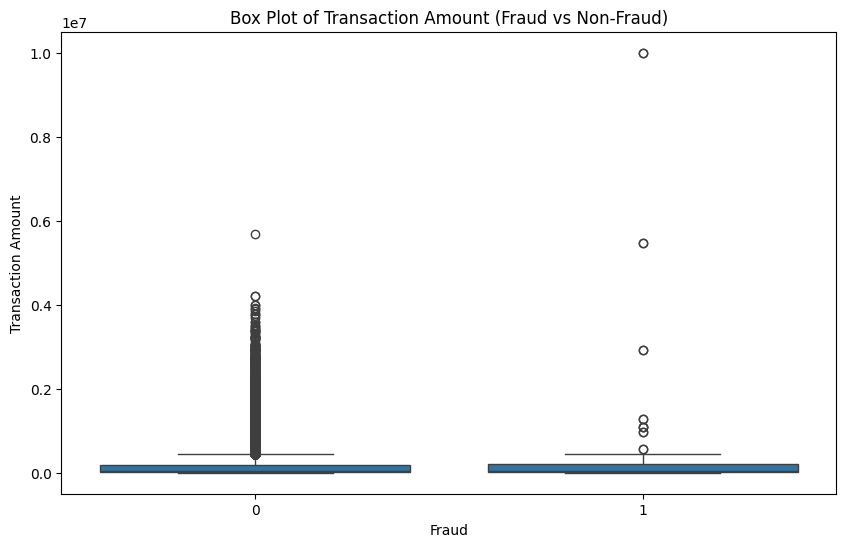

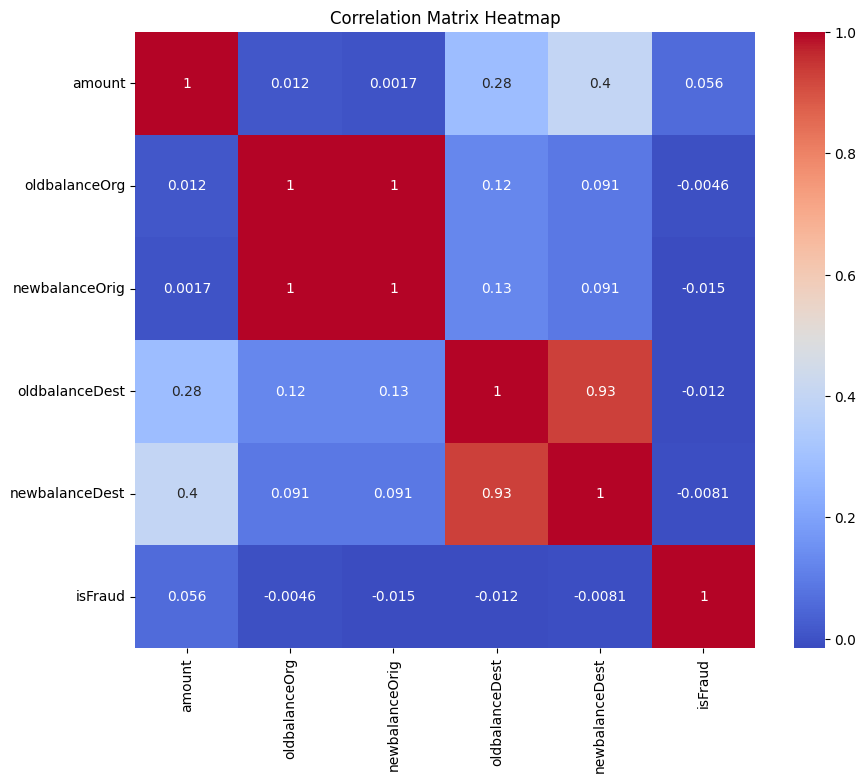

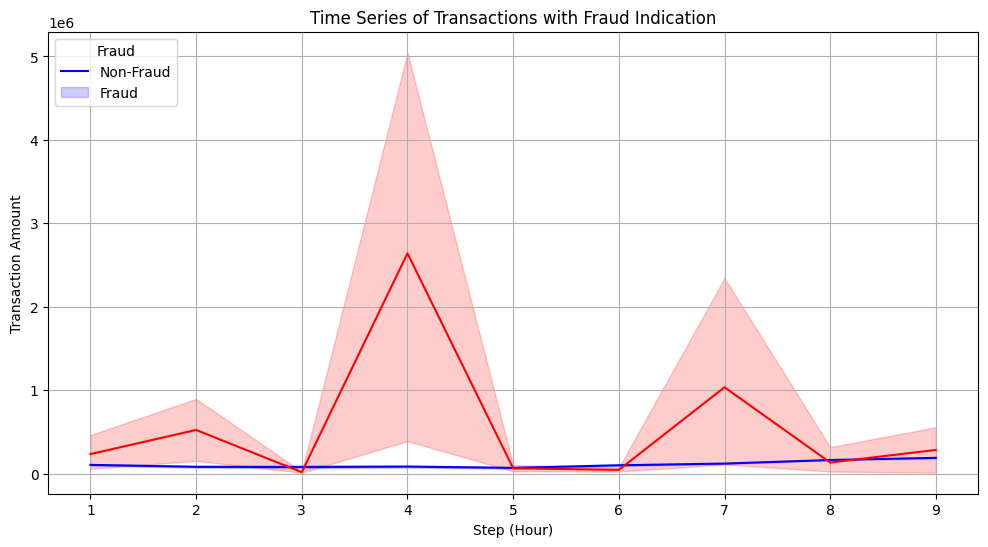

<Figure size 1200x1200 with 0 Axes>

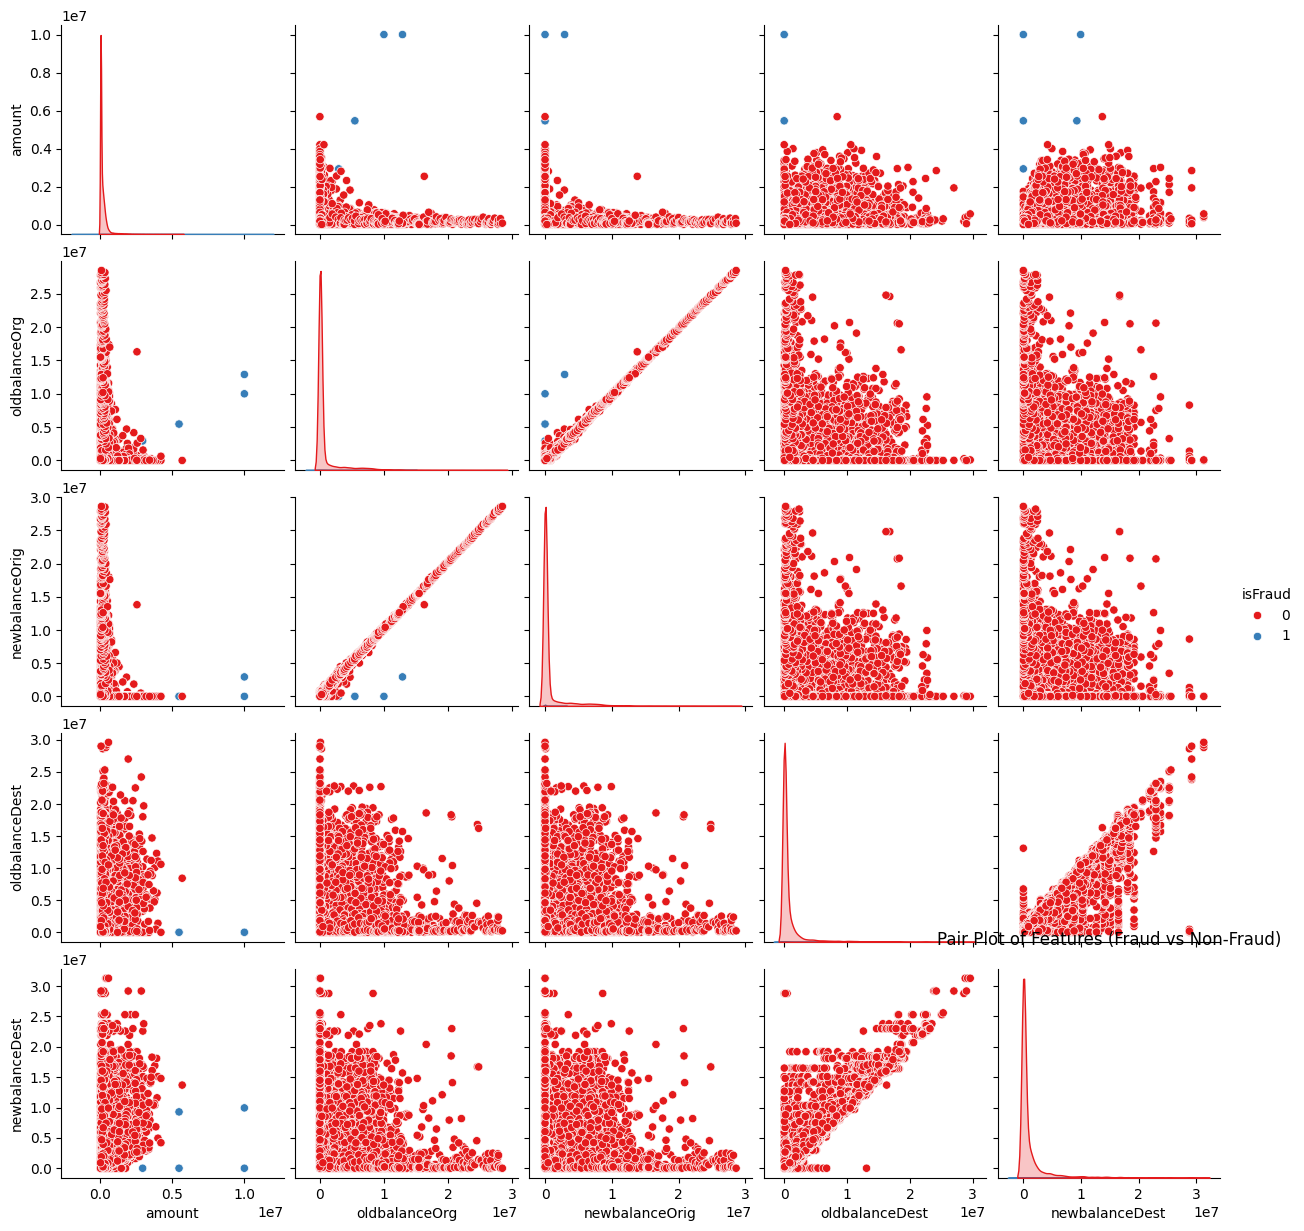


Evaluation Metrics:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     44505
           1       0.00      0.15      0.01        94

    accuracy                           0.90     44599
   macro avg       0.50      0.52      0.48     44599
weighted avg       1.00      0.90      0.94     44599



In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

df = pd.read_csv('DATASET.csv')
print("Initial Data:")
print(df.head())

# Feature Engineering
df['hour'] = df['step'] % 24
df['day'] = df['step'] // 24

# Data Preprocessing
df_numeric = df.drop(['step', 'nameOrig', 'nameDest', 'type'], axis=1)
df_numeric.fillna(df_numeric.mean(), inplace=True)

# Scaling the data (convert to NumPy array)
features = df_numeric.drop(['isFraud', 'isFlaggedFraud'], axis=1).values
scaler = StandardScaler()
df_scaled = scaler.fit_transform(features)

# Train Isolation Forest model
model = IsolationForest(contamination=0.1, random_state=42)
model.fit(df_scaled)

# Predict anomalies
df['anomaly'] = model.predict(df_scaled)
df['anomaly'] = np.where(df['anomaly'] == -1, 1, 0)

# Handle NaN and datatype conversion
df['isFraud'] = pd.to_numeric(df['isFraud'], errors='coerce').fillna(0).astype(int)
df['anomaly'] = pd.to_numeric(df['anomaly'], errors='coerce').fillna(0).astype(int)

# 1. Confusion Matrix Heatmap
conf_matrix = confusion_matrix(df['isFraud'], df['anomaly'])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title('Confusion Matrix for Fraud Detection')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 2. Box Plot of Transaction Amount for Fraud vs Non-Fraud
plt.figure(figsize=(10, 6))
sns.boxplot(x='isFraud', y='amount', data=df)
plt.title('Box Plot of Transaction Amount (Fraud vs Non-Fraud)')
plt.xlabel('Fraud')
plt.ylabel('Transaction Amount')
plt.show()

# 3. Correlation Matrix Heatmap
plt.figure(figsize=(10, 8))
correlation = df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

# 4. Time Series Plot of Transactions
plt.figure(figsize=(12, 6))
sns.lineplot(x='step', y='amount', hue='isFraud', palette=['blue', 'red'], data=df)
plt.title('Time Series of Transactions with Fraud Indication')
plt.xlabel('Step (Hour)')
plt.ylabel('Transaction Amount')
plt.legend(title='Fraud', loc='upper left', labels=['Non-Fraud', 'Fraud'])
plt.grid(True)
plt.show()

# 5. Pair Plot of Important Features
plt.figure(figsize=(12, 12))
sns.pairplot(df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud']], hue='isFraud', palette='Set1')
plt.title('Pair Plot of Features (Fraud vs Non-Fraud)')
plt.show()

# Classification Report
print("\nEvaluation Metrics:")
print(classification_report(df['isFraud'], df['anomaly']))


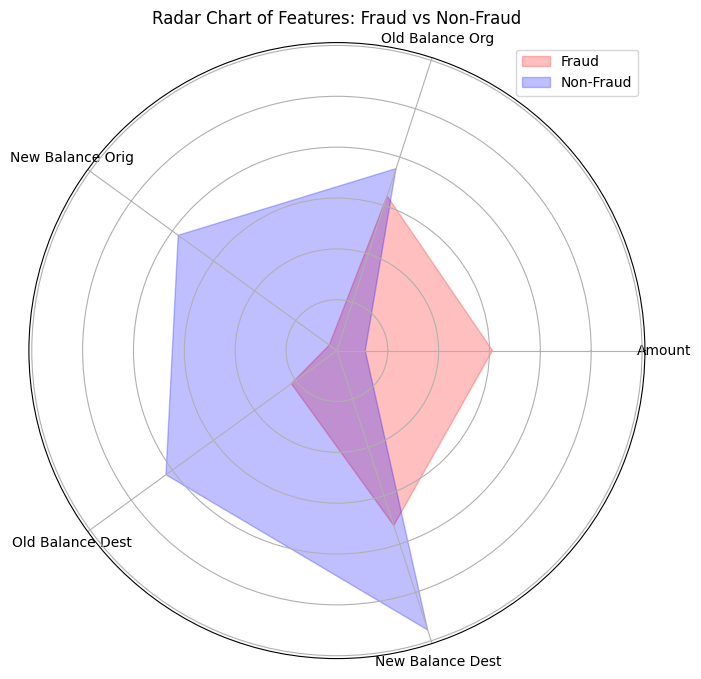

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('DATASET.csv')


fraud_df = df[df['isFraud'] == 1]

categories = ['Amount', 'Old Balance Org', 'New Balance Orig', 'Old Balance Dest', 'New Balance Dest']
fraud_mean = [
    fraud_df['amount'].mean(),
    fraud_df['oldbalanceOrg'].mean(),
    fraud_df['newbalanceOrig'].mean(),
    fraud_df['oldbalanceDest'].mean(),
    fraud_df['newbalanceDest'].mean()
]
non_fraud_mean = [
    df[df['isFraud'] == 0]['amount'].mean(),
    df[df['isFraud'] == 0]['oldbalanceOrg'].mean(),
    df[df['isFraud'] == 0]['newbalanceOrig'].mean(),
    df[df['isFraud'] == 0]['oldbalanceDest'].mean(),
    df[df['isFraud'] == 0]['newbalanceDest'].mean()
]

# Create radar chart
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
fraud_mean += fraud_mean[:1]
non_fraud_mean += non_fraud_mean[:1]
angles += angles[:1]

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
ax.fill(angles, fraud_mean, color='red', alpha=0.25)
ax.fill(angles, non_fraud_mean, color='blue', alpha=0.25)
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
plt.title('Radar Chart of Features: Fraud vs Non-Fraud')
plt.legend(['Fraud', 'Non-Fraud'])
plt.show()



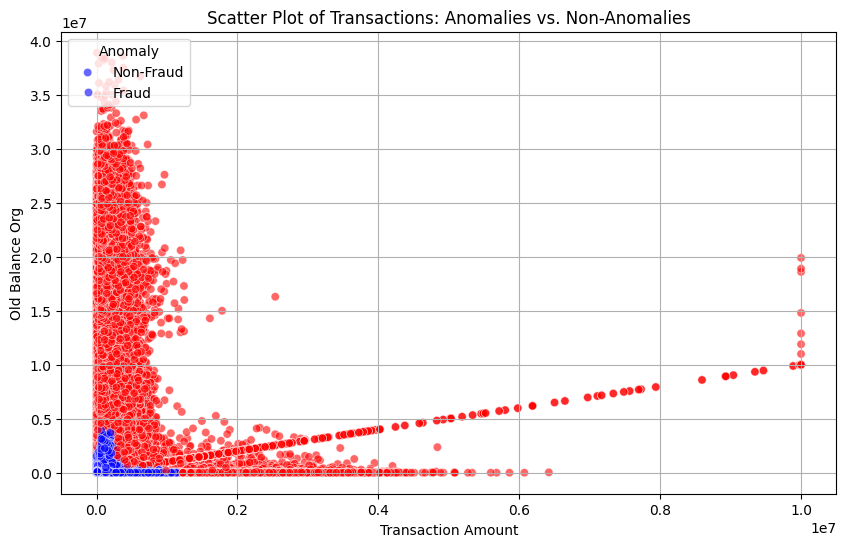

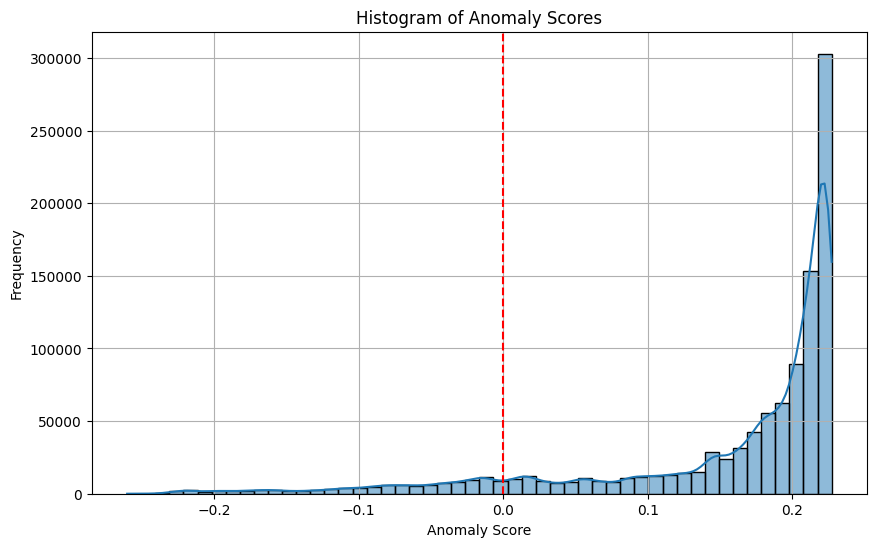

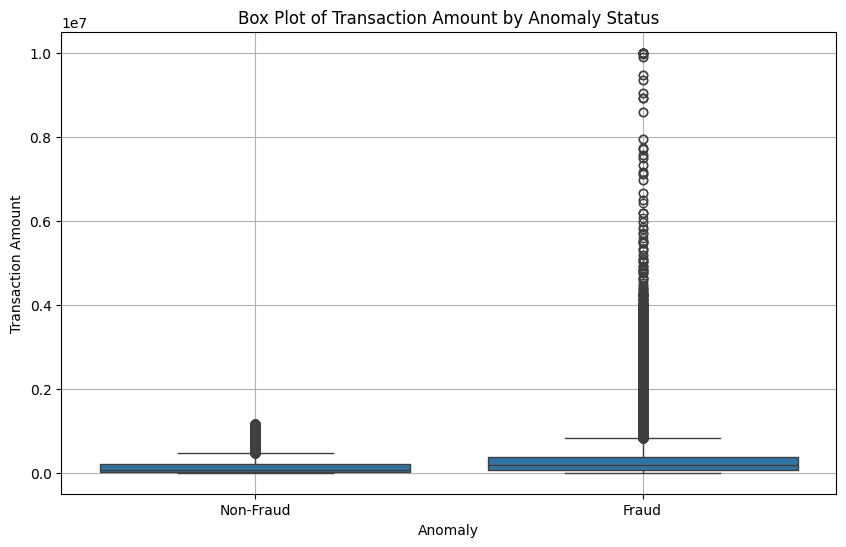

Total transactions: 1048575
Detected fraud transactions: 104858


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest

df = pd.read_csv('DATASET.csv')

# Data Preprocessing
df.fillna(0, inplace=True)  # Handle missing values

# Prepare data for Isolation Forest
features = df[['amount', 'oldbalanceOrg', 'newbalanceOrig']]

# Train Isolation Forest model
model = IsolationForest(contamination=0.1, random_state=42)
model.fit(features)

# Predict anomalies
df['anomaly'] = model.predict(features)
df['anomaly'] = df['anomaly'].apply(lambda x: 1 if x == -1 else 0)

# Get anomaly scores
df['anomaly_score'] = model.decision_function(features)

# 1. Scatter Plot of Transactions
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='amount', y='oldbalanceOrg', hue='anomaly', palette={0: 'blue', 1: 'red'}, alpha=0.6)
plt.title('Scatter Plot of Transactions: Anomalies vs. Non-Anomalies')
plt.xlabel('Transaction Amount')
plt.ylabel('Old Balance Org')
plt.legend(title='Anomaly', loc='upper left', labels=['Non-Fraud', 'Fraud'])
plt.grid(True)
plt.show()

# 2. Histogram of Anomaly Scores
plt.figure(figsize=(10, 6))
sns.histplot(df['anomaly_score'], bins=50, kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.title('Histogram of Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 3. Box Plot of Transaction Amount by Anomaly Status
plt.figure(figsize=(10, 6))
sns.boxplot(x='anomaly', y='amount', data=df)
plt.title('Box Plot of Transaction Amount by Anomaly Status')
plt.xlabel('Anomaly')
plt.ylabel('Transaction Amount')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.grid(True)
plt.show()

# Summary of detected anomalies
print(f"Total transactions: {len(df)}")
print(f"Detected fraud transactions: {df['anomaly'].sum()}")
